In [196]:
import pandas as pd

In [197]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [198]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [199]:
# Data Prpearation
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [200]:
cat = ['lead_source', 'industry', 'employment_status', 'location']

num = ['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score', 'converted']

In [201]:
df[cat] = df[cat].fillna('NA')

df[num] = df[num].fillna(0.0)

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [202]:
# Split data into train, validate and test using scikit learn

from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state =1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state =1)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [203]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [204]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [205]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [206]:
# 1.)ROC AUC feature importance
# For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.

num_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score']
from sklearn.metrics import roc_auc_score
auc_scores = {}
for col in num_features:
    # 1. Use the numerical variable as score/prediction
    y_pred = df_train[col]
    auc = roc_auc_score(y_train, y_pred)

    # 3. Check if AUC < 0.5 and invert if necessary
    if auc < 0.5:
        y_pred_inverted = -df_train[col] # Invert the score
        final_auc = roc_auc_score(y_train, y_pred_inverted)
    else:
        final_auc = auc
    auc_scores[col] = final_auc
    print(f"Feature: {col}, Initial AUC: {auc:.4f}, Final AUC: {final_auc:.4f}")


Feature: number_of_courses_viewed, Initial AUC: 0.7636, Final AUC: 0.7636
Feature: annual_income, Initial AUC: 0.5520, Final AUC: 0.5520
Feature: interaction_count, Initial AUC: 0.7383, Final AUC: 0.7383
Feature: lead_score, Initial AUC: 0.6145, Final AUC: 0.6145


In [207]:
# 4. Find the variable with the highest final AUC
highest_auc_feature = max(auc_scores, key=auc_scores.get)
highest_auc_feature

'number_of_courses_viewed'

In [208]:
#2.) Training the model and find AUC of Validation Data

categorical = ['lead_source', 'industry', 'employment_status', 'location']

numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score']

# one-hot encoding
#Training Data
from sklearn.feature_extraction import DictVectorizer
dicts = df_train[categorical + numerical].to_dict(orient = 'records')
dv = DictVectorizer(sparse = False)
x_train = dv.fit_transform(dicts)

#Logical regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(x_train, y_train)

#Validation data 
dicts_val = df_val[categorical + numerical].to_dict(orient = 'records')
x_val = dv.transform(dicts_val)
y_pred = model.predict_proba(x_val)[:,1]

# Compute AUC
auc_val = roc_auc_score(y_val, y_pred)

# Round the result to 3 digits
auc_val_rounded = round(auc_val, 3)

In [243]:
auc_val_rounded 


0.817

In [210]:
# Precision & Recall vs threshold; find intersection

import numpy as np
from sklearn.metrics import precision_score, recall_score


thresholds = np.linspace(0.0, 1.0, 101) # [0.00, 0.01, ..., 1.00]
scores = []

for t in thresholds:
    # Convert probability to binary prediction
    y_pred_binary = (y_pred >= t)
    
    # Compute Precision and Recall
    # zero_division=0 prevents runtime warnings when there are no positive predictions (e.g., at t=1.0)
    precision = precision_score(y_val, y_pred_binary, average='weighted', zero_division='warn')
    recall = recall_score(y_val, y_pred_binary, average='weighted', zero_division=0)
    
    scores.append((t, precision, recall))

df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall'])

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/

In [211]:
df_scores

,threshold,precision,recall
0,0.00,0.340610,0.583618
1,0.01,0.340610,0.583618
2,0.02,0.340610,0.583618
3,0.03,0.340610,0.583618
4,0.04,0.340610,0.583618
...,...,...,...
96,0.96,0.758785,0.426621
97,0.97,0.757586,0.419795
98,0.98,0.173374,0.416382
99,0.99,0.173374,0.416382


In [212]:
df_scores['diff'] = np.abs(df_scores.precision - df_scores.recall)
intersection_threshold_row = df_scores.loc[df_scores['diff'].idxmin()]

In [213]:
intersection_threshold_row

threshold    0.640000
precision    0.743738
recall       0.744027
diff         0.000290
Name: 64, dtype: float64

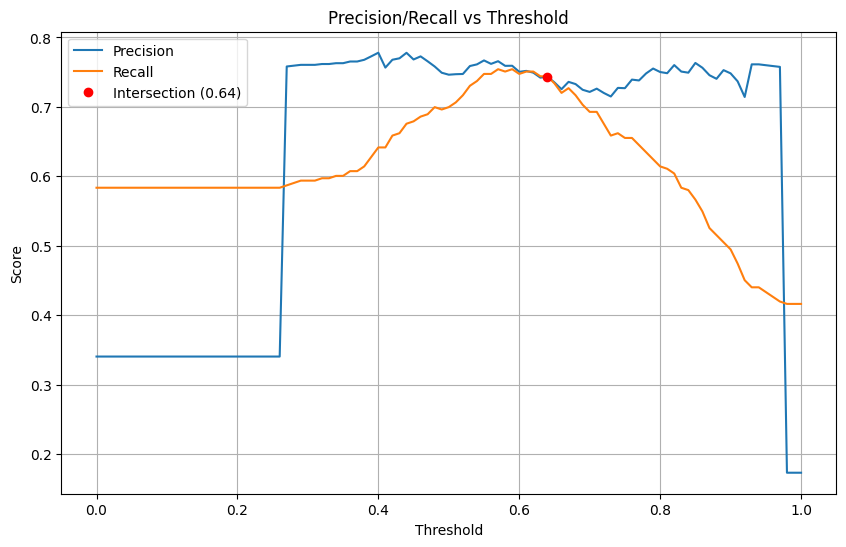

In [214]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall')

# Highlight the intersection point
t_intersect = intersection_threshold_row['threshold']
p_r_intersect = intersection_threshold_row['precision'] # Since P ≈ R at intersection
plt.plot(t_intersect, p_r_intersect, 'ro', label=f'Intersection ({t_intersect:.2f})') 

plt.xlabel('Threshold'); 
plt.ylabel('Score'); 
plt.title('Precision/Recall vs Threshold')
plt.legend(); 
plt.grid(True)
plt.show()

In [215]:
# 0.64 is the answer

In [224]:
#Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 101)
score = {}
max_f1 = 0
max_threshold = 0
for t in thresholds:
    y_pred_binary =(y_pred >= t).astype(int)
    score[t] = f1_score(y_val, y_pred_binary)

    if score[t] > max_f1:
        max_f1 = score[t]
        max_threshold = t

        
    

In [227]:
max_threshold, max_f1

(np.float64(0.5700000000000001), 0.8125)

In [230]:
from sklearn.model_selection import KFold

# 1. Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores_cv = []

# 2. Loop through 5 folds
for train_idx, val_idx in kfold.split(df_full_train):
    
    # Split data for the current fold
    df_train_f = df_full_train.iloc[train_idx]
    df_val_f = df_full_train.iloc[val_idx]

    y_train_f = df_train_f['converted'].values
    y_val_f = df_val_f['converted'].values

    # Feature preparation (Fit DictVectorizer ONLY on train_fold)
    dv = DictVectorizer(sparse=False)
    X_train_f = dv.fit_transform(df_train_f[categorical + numerical].to_dict(orient='records'))
    X_val_f = dv.transform(df_val_f[categorical + numerical].to_dict(orient='records'))

    # Train Model 
    model_f = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model_f.fit(X_train_f, y_train_f)

    # Predict and Score
    y_pred_val_f = model_f.predict_proba(X_val_f)[:, 1]
    auc_score = roc_auc_score(y_val_f, y_pred_val_f)
    auc_scores_cv.append(auc_score)

# 3. Compute Standard Deviation
std_dev_auc = np.std(auc_scores_cv)

In [231]:
std_dev_auc

np.float64(0.03580711942905165)

In [240]:
# 1. Initialize KFold

c = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

res = {}

# 2. Loop through 5 folds
for c in c:
    auc_scores_cv = []
    for train_idx, val_idx in kfold.split(df_full_train):
        
        # Split data for the current fold
        df_train_f = df_full_train.iloc[train_idx]
        df_val_f = df_full_train.iloc[val_idx]
    
        y_train_f = df_train_f['converted'].values
        y_val_f = df_val_f['converted'].values
    
        # Feature preparation (Fit DictVectorizer ONLY on train_fold)
        dv = DictVectorizer(sparse=False)
        X_train_f = dv.fit_transform(df_train_f[categorical + numerical].to_dict(orient='records'))
        X_val_f = dv.transform(df_val_f[categorical + numerical].to_dict(orient='records'))
    
        # Train Model 
        model_f = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=1)
        model_f.fit(X_train_f, y_train_f)
    
        # Predict and Score
        y_pred_val_f = model_f.predict_proba(X_val_f)[:, 1]
        auc_score = roc_auc_score(y_val_f, y_pred_val_f)
        auc_scores_cv.append(auc_score)

    res[c] = {
    'mean_auc': round(np.mean(auc_scores_cv),3),
    'std_auc': round(np.std(auc_scores_cv),3)
    }

In [241]:
res

{1e-06: {'mean_auc': np.float64(0.56), 'std_auc': np.float64(0.024)},
 0.001: {'mean_auc': np.float64(0.867), 'std_auc': np.float64(0.029)},
 1: {'mean_auc': np.float64(0.822), 'std_auc': np.float64(0.036)}}

In [242]:
# best mean score is 0.867 at c = 0.001